Data Analysis for the results

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# --- 📂 Load CSVs ---

In [2]:
# Step 1: Load clean Unity CSV
unity = pd.read_csv("unity_terminal_bearing.csv", skipinitialspace=True)
if "Unnamed: 5" in unity.columns:
    unity = unity.drop(columns=["Unnamed: 5"])  # Clean index col if needed

# Fix bad headers if necessary (only if columns look like positions)
if unity.columns[0].startswith("("):
    unity.columns = ["ID", "Position", "Yaw"]

# Step 2: Load and clean South CSV
south = pd.read_csv("south_terminal_bearing.csv", skipinitialspace=True)
south = south.dropna(axis=1, how='all')  # Drop fully empty columns
if "Unnamed: 0" in south.columns:
    south = south.drop(columns=["Unnamed: 0"])

In [3]:
print("south columns:", south.columns)
print("unity columns:", unity.columns)

south columns: Index(['ID', 'Easting', 'Northing', 'Yaw', 'Bearing'], dtype='object')
unity columns: Index(['ID', 'Easting', 'Northing', 'Yaw', 'Bearing'], dtype='object')


# --- 🧮 Normalize angles modulo 180 ---


In [4]:
def parse_bearing(bearing):
    try:
        return float(str(bearing).replace("°", "").replace("W", "").replace("E", "").strip())
    except:
        return None

def compass_to_yaw(bearing):
    return (90 - bearing) % 360

def normalize_angle(angle):
    return angle % 90 # since containers are symmetric every 180°

# Reference bearing (in degrees, from West direction)
ref_bearing_deg = 172.629578
ref_yaw = normalize_angle(compass_to_yaw(ref_bearing_deg))

print(f"Reference yaw (from 172.63°W): {ref_yaw:.2f}°")

Reference yaw (from 172.63°W): 7.37°


# --- 🔍 Error computation ---

In [5]:
south["Parsed_Bearing"] = south["Bearing"].apply(parse_bearing)
south["Bearing_norm"] = south["Parsed_Bearing"].apply(lambda b: normalize_angle(compass_to_yaw(b)))
south["Yaw_norm"] = south["Yaw"].apply(normalize_angle)
south["Angle_Diff"] = abs(south["Yaw_norm"] - south["Bearing_norm"])
south["Angle_Diff"] = np.minimum(south["Angle_Diff"], 180 - south["Angle_Diff"])

In [6]:
unity["Parsed_Bearing"] = unity["Bearing"].apply(parse_bearing)
unity["Bearing_norm"] = unity["Parsed_Bearing"].apply(lambda b: normalize_angle(compass_to_yaw(b)))
# Convert Yaw to numeric explicitly (coerce errors into NaN)
unity["Yaw"] = pd.to_numeric(unity["Yaw"], errors="coerce")

# Now apply normalization safely
unity["Yaw_norm"] = unity["Yaw"].apply(normalize_angle)

# Align Unity yaw to the reference
unity["Yaw_ref_norm"] = (unity["Yaw_norm"] - ref_yaw) % 180
unity["Bearing_ref_norm"] = (unity["Bearing_norm"] - ref_yaw) % 180

unity["Angle_Diff"] = abs(unity["Yaw_ref_norm"] - unity["Bearing_ref_norm"])
unity["Angle_Diff"] = np.minimum(unity["Angle_Diff"], 180 - unity["Angle_Diff"])

In [7]:
# Check if Angle_Diff exists and is numeric
print("Unity columns:", unity.columns)
print("Non-numeric in Angle_Diff:", pd.to_numeric(unity["Angle_Diff"], errors='coerce').isna().sum())
print("NaN values:", unity["Angle_Diff"].isna().sum())
print("Sample values:\n", unity["Angle_Diff"].head())

Unity columns: Index(['ID', 'Easting', 'Northing', 'Yaw', 'Bearing', 'Parsed_Bearing',
       'Bearing_norm', 'Yaw_norm', 'Yaw_ref_norm', 'Bearing_ref_norm',
       'Angle_Diff'],
      dtype='object')
Non-numeric in Angle_Diff: 0
NaN values: 0
Sample values:
 0     8.854477
1     4.823057
2    16.130335
3     4.557914
4    25.333004
Name: Angle_Diff, dtype: float64


# --- 📊 Visualization ---

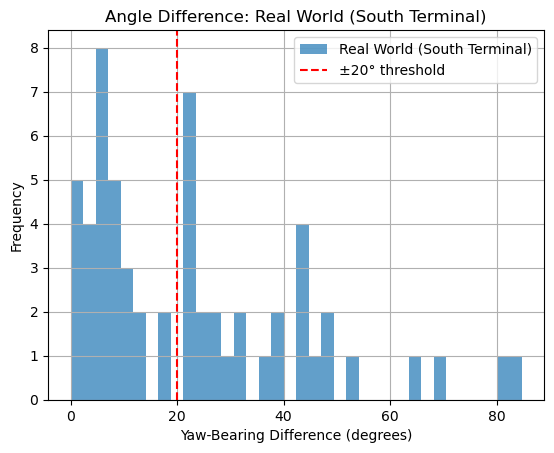

Real World (South Terminal): 29/58 within ±20° threshold (50.0%)


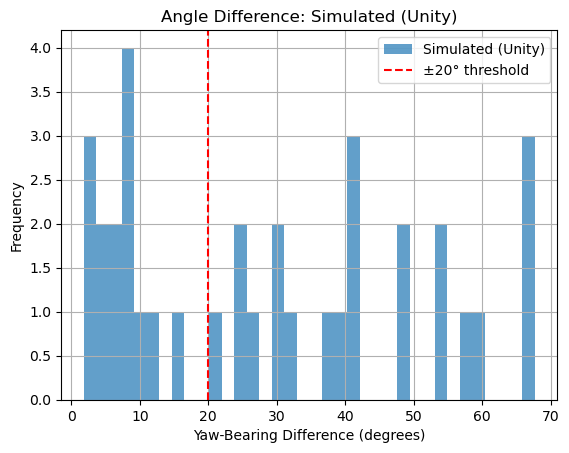

Simulated (Unity): 14/35 within ±20° threshold (40.0%)


In [8]:
def plot_angle_diff(data, label, threshold=20):
    plt.hist(data["Angle_Diff"], bins=36, alpha=0.7, label=label)
    plt.axvline(threshold, color="red", linestyle="--", label="±20° threshold")
    plt.xlabel("Yaw-Bearing Difference (degrees)")
    plt.ylabel("Frequency")
    plt.title(f"Angle Difference: {label}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Count how many are within threshold
    within = (data["Angle_Diff"] <= threshold).sum()
    total = len(data)
    print(f"{label}: {within}/{total} within ±{threshold}° threshold "
          f"({(within / total) * 100:.1f}%)")

# Plot both
plot_angle_diff(south, "Real World (South Terminal)")
plot_angle_diff(unity, "Simulated (Unity)")

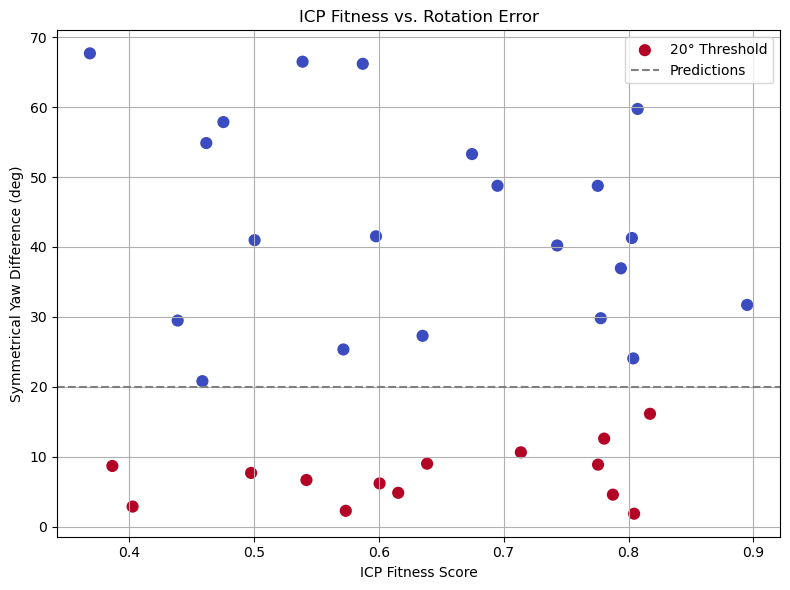

In [16]:
# Load your new pipeline results (with Fitness scores)
pose_df = pd.read_csv("pose_unity_terminal.csv")  # This has ID, Yaw, Fitness

# Merge it with the already-processed Unity DataFrame
unitymerged_df = pd.merge(unity, pose_df[["ID", "Fitness"]], on="ID", how="inner")

# Plot Fitness vs. Angular Error (already computed as Angle_Diff)
plt.figure(figsize=(8,6))
plt.scatter(unitymerged_df["Fitness"], unitymerged_df["Angle_Diff"], c=unitymerged_df["Angle_Diff"] <= 20, cmap="coolwarm", s=60)
plt.axhline(20, color='gray', linestyle='--', label="20° threshold")
plt.xlabel("ICP Fitness Score")
plt.ylabel("Symmetrical Yaw Difference (deg)")
plt.title("ICP Fitness vs. Rotation Error")
plt.legend(["20° Threshold", "Predictions"])
plt.grid(True)
plt.tight_layout()
plt.show()

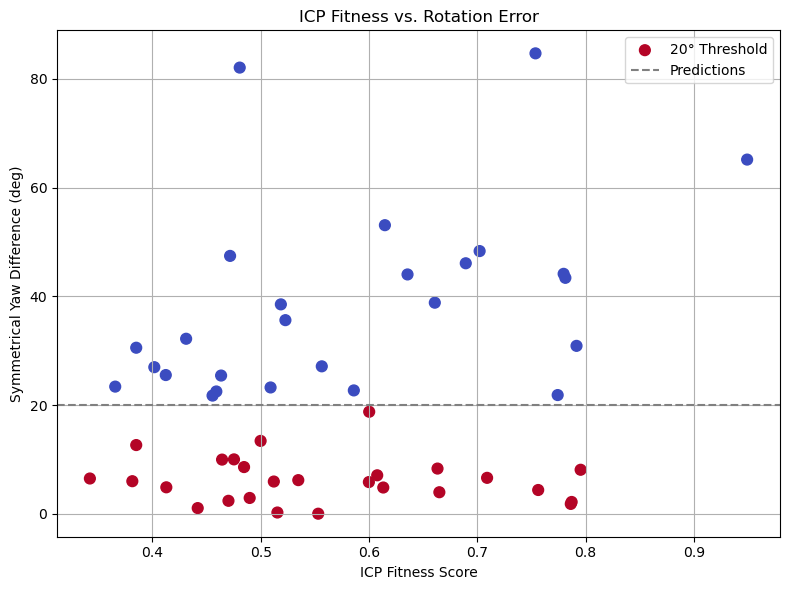

In [17]:
# Load your new pipeline results (with Fitness scores)
pose_df = pd.read_csv("pose_south_terminal.csv")  # This has ID, Yaw, Fitness

# Merge it with the already-processed Unity DataFrame
southmerged_df = pd.merge(south, pose_df[["ID", "Fitness"]], on="ID", how="inner")

# Plot Fitness vs. Angular Error (already computed as Angle_Diff)
plt.figure(figsize=(8,6))
plt.scatter(southmerged_df["Fitness"], southmerged_df["Angle_Diff"], c=southmerged_df["Angle_Diff"] <= 20, cmap="coolwarm", s=60)
plt.axhline(20, color='gray', linestyle='--', label="20° threshold")
plt.xlabel("ICP Fitness Score")
plt.ylabel("Symmetrical Yaw Difference (deg)")
plt.title("ICP Fitness vs. Rotation Error")
plt.legend(["20° Threshold", "Predictions"])
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
from scipy.stats import pearsonr
import statsmodels.api as sm


corr, p_value = pearsonr(southmerged_df["Fitness"], southmerged_df["Angle_Diff"])
print(f"South Terminal: Pearson r: {corr:.3f}, p-value: {p_value:.4f}")
print("Linear Regression")

X = southmerged_df["Fitness"]
y = southmerged_df["Angle_Diff"]
X = sm.add_constant(X)  # Adds intercept

model = sm.OLS(y, X).fit()
print(model.summary())

corr, p_value = pearsonr(unitymerged_df["Fitness"], unitymerged_df["Angle_Diff"])
print(f"Unity Terminal: Pearson r: {corr:.3f}, p-value: {p_value:.4f}")

print("Linear Regression")
X = unitymerged_df["Fitness"]
y = unitymerged_df["Angle_Diff"]
X = sm.add_constant(X)  # Adds intercept

model = sm.OLS(y, X).fit()
print(model.summary())




South Terminal: Pearson r: 0.247, p-value: 0.0778
Linear Regression
                            OLS Regression Results                            
Dep. Variable:             Angle_Diff   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     3.243
Date:                Thu, 29 May 2025   Prob (F-statistic):             0.0778
Time:                        14:12:06   Log-Likelihood:                -229.04
No. Observations:                  52   AIC:                             462.1
Df Residuals:                      50   BIC:                             466.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------